# Сбор данных о точках интереса в окрестностях банкоматов

## Подсчет типов и количества точек интереса по переданным координатам

In [42]:
from collections import Counter
from pprint import pprint

import geopandas as gpd
import numpy as np
import pandas as pd
import pyrosm
from cartopy.geodesic import Geodesic
from shapely.geometry import Polygon, Point
from tqdm import tqdm

- для работы с данными OpenStreetMap используем дамп карты в границах РФ, который можно скачать по [ссылке](https://download.geofabrik.de/russia-latest.osm.pbf) со страницы сайта [https://download.geofabrik.de/russia.html](https://download.geofabrik.de/russia.html)
- очищаем дамп от ненужной нам информации при помощи утилиты [Osmium Tool](https://osmcode.org/osmium-tool/manual.html)
- для этого необходимо установить утилиту, открыть консоль, перейти в директорию с дампом и выполнить команду:
```bash
osmium tags-filter russia-latest.osm.pbf nwr/amenity nwr/building nwr/craft nwr/historic nwr/leisure nwr/office nwr/public_transport nwr/shop nwr/sport nwr/tourism -o filtered-russia.osm.pbf
```
- отфильтрованный дамп должен сохраниться в файл `filtered-russia.osm.pbf`
- уже очищенный дамп можно скачать по [ссылке](https://drive.google.com/file/d/1DiY6NZGdf8f8OekXNxYA0a45vpBG_j90/view?usp=sharing)

Создадим geopandas dataframe на основе дампа. **ВНИМАНИЕ !!! Этот процесс может занять больше 20 мин.**
TODO: Придумать, как ускорить процесс загрузки датафрейма. Если не хочется столько ждать, можно загрузить отдельный город (см. следующий под этим блок кода).

In [80]:
# Базовый способ получить карту РФ
osm = pyrosm.OSM("../../../datasets/filtered-russia-06-11.osm.pbf")  # Укажите путь к файлу, который скачали или подготовили

In [3]:
# Альтернативный способ получить дамп карты (можно загрузить отдельный город или даже район)
# см. документацию pyrosm https://pyrosm.readthedocs.io/en/latest/basics.html
from pyrosm import get_data

fp = get_data("Moscow")  # Указать нужный город или область
osm = pyrosm.OSM(fp)

Downloaded Protobuf data 'Moscow.osm.pbf' (45.09 MB) to:
'/var/folders/2g/mntq94qs79g4yxgrw9558m3m0000gn/T/pyrosm/Moscow.osm.pbf'


In [81]:
my_filter = {
    "amenity": True,
    "shop": True,
    "leisure": True,
    "office": True,
    "public_transport": True,
    "tourism": True,
}
main_gpdf = osm.get_pois(
    custom_filter=my_filter
)
main_gpdf = main_gpdf.copy()  # Дефрагментация датафрейма


/Users/antonzajcev/code/HSE/first_year_project/atm-project/venv/lib/python3.10/site-packages/pyrosm/pois.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gdf = prepare_geodataframe(
/Users/antonzajcev/code/HSE/first_year_project/atm-project/venv/lib/python3.10/site-packages/pyrosm/pois.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gdf = prepare_geodataframe(
/Users/antonzajcev/code/HSE/first_year_project/atm-project/venv/lib/python3.10/site-packages/pyrosm/pois.py:38: PerformanceWarning: DataFrame is highly fragmented

In [ ]:
def get_poi_count_near_point(
        df: gpd.GeoDataFrame,
        point_lon: float,
        point_lat: float,
        radius: int,
        tag_types: list[str],
        plot_maps: bool = False
) -> dict[str, int]:
    """Получить количество точек интереса по типам в радиусе заданной точки.
    Описание тегов можно получить на странице https://wiki.openstreetmap.org/wiki/Map_features
    Проблема: Работает очень медленно с картой РФ (более 10 с на запрос)
    """
    gd = Geodesic()
    circle_polygon = Polygon(gd.circle(lon=point_lon, lat=point_lat, radius=radius))
    circle_gdf = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[circle_polygon])
    # аргумент predicate="intersects" позволяет учесть не только точечные объекты,
    # но и формы (например большой торговый центр), которые пересекают окружность
    # писка. Проблема - на карте могут отображаться протяженные объекты, которые
    # попали в выборку и мешать отрисовке карты в нормальном масштабе.
    # gdf_selection = gpd.sjoin(df, circle_gdf, predicate="intersects")

    # аргумент predicate="within" - учитываем только объекты внутри окружности
    # поиска. Не учитывает формы, пересекающие границу поиска.
    gdf_selection = gpd.sjoin(df, circle_gdf, predicate="within")
    tags_count_by_types = {}
    for tag_type in tag_types:
        gdf_selection[tag_type] = gdf_selection[tag_type].fillna("other_types")
        tags_count_by_types[tag_type] = dict(gdf_selection[tag_type].value_counts())
        if plot_maps:
            ax = gdf_selection.plot(
                column=tag_type, markersize=10, figsize=(16, 16), legend=True,
                legend_kwds=dict(loc="upper left", ncol=5, bbox_to_anchor=(1, 1))
            )
            ax.set_title(tag_type)
    # TODO: Необходимо переработать функцию, чтобы она возвращала только те теги,
    # которые нам нужны для анализа, предварительно группируя их по типам.
    return tags_count_by_types

In [82]:
def get_poi_count_near_point_using_r_tree(
        df: gpd.GeoDataFrame,
        point_lon: float,
        point_lat: float,
        radius: int,
        tag_types: list[str],
        plot_maps: bool = False
) -> dict[str, int]:
    """Получить количество точек интереса по типам в радиусе заданной точки.
    Используется индексирование R-tree для ускорения поиска.
    см. статью про использование  R-tree https://geoffboeing.com/2016/10/r-tree-spatial-index-python/
    Описание тегов можно получить на странице https://wiki.openstreetmap.org/wiki/Map_features
    """
    gd = Geodesic()
    circle_polygon = Polygon(gd.circle(lon=point_lon, lat=point_lat, radius=radius))

    # Быстрая фильтрация предварительных результатов с использованием R-tree index
    spatial_index = df.sindex
    possible_matches_index = list(spatial_index.intersection(circle_polygon.bounds))
    possible_matches = df.iloc[possible_matches_index]

    # Подробная фильтрация
    gdf_selection = possible_matches[possible_matches.intersects(circle_polygon)]

    tags_count_by_types = {}
    for tag_type in tag_types:
        tags_count_by_types[tag_type] = dict(gdf_selection.loc[:, tag_type].value_counts())
        if plot_maps:
            ax = gdf_selection.plot(
                column=tag_type, markersize=10, figsize=(16, 16), legend=True,
                legend_kwds=dict(loc="upper left", ncol=5, bbox_to_anchor=(1, 1))
            )
            ax.set_title(tag_type)
    return tags_count_by_types

### Тестируем функцию поиска POI
Можно указать любые координаты в пределах РФ и область поиска `radius` в метрах. На картах отсутствует дорожная сеть и строения для уменьшения размера карты, но при
желании можно загрузить полный дамп и добавить дороги и дома для наглядности.

IndexError: index 0 is out of bounds for axis 0 with size 0

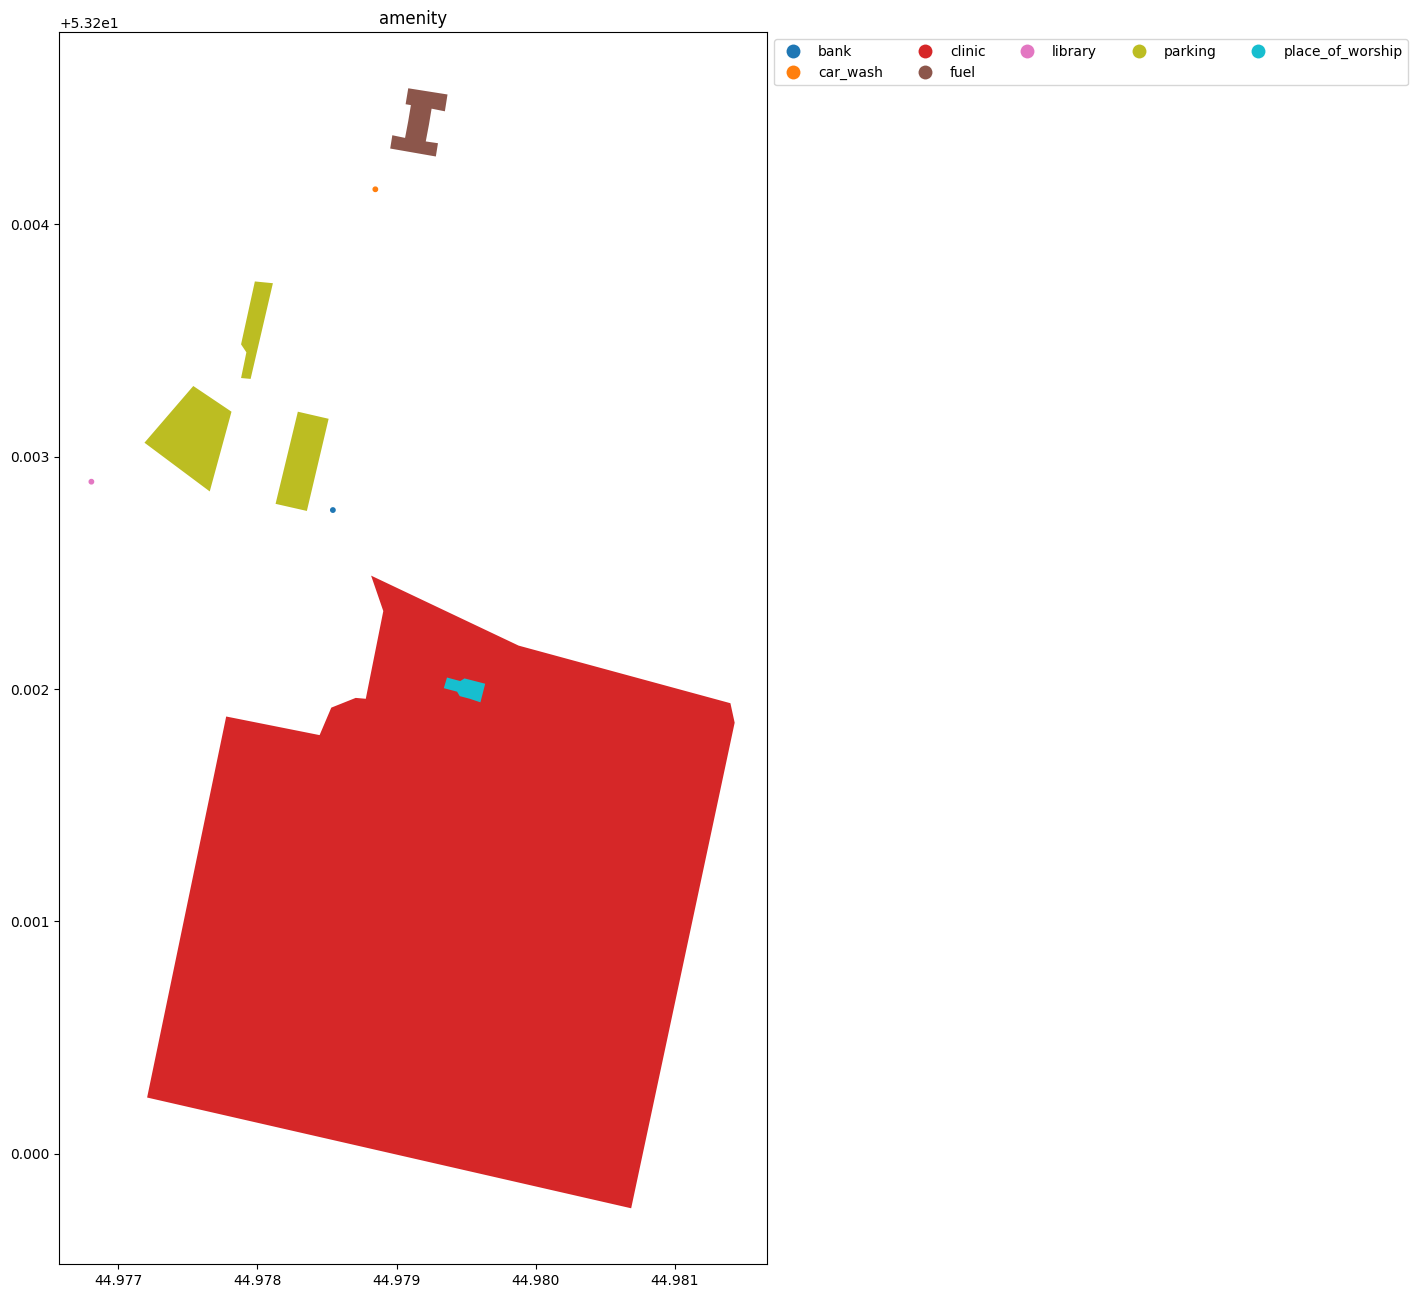

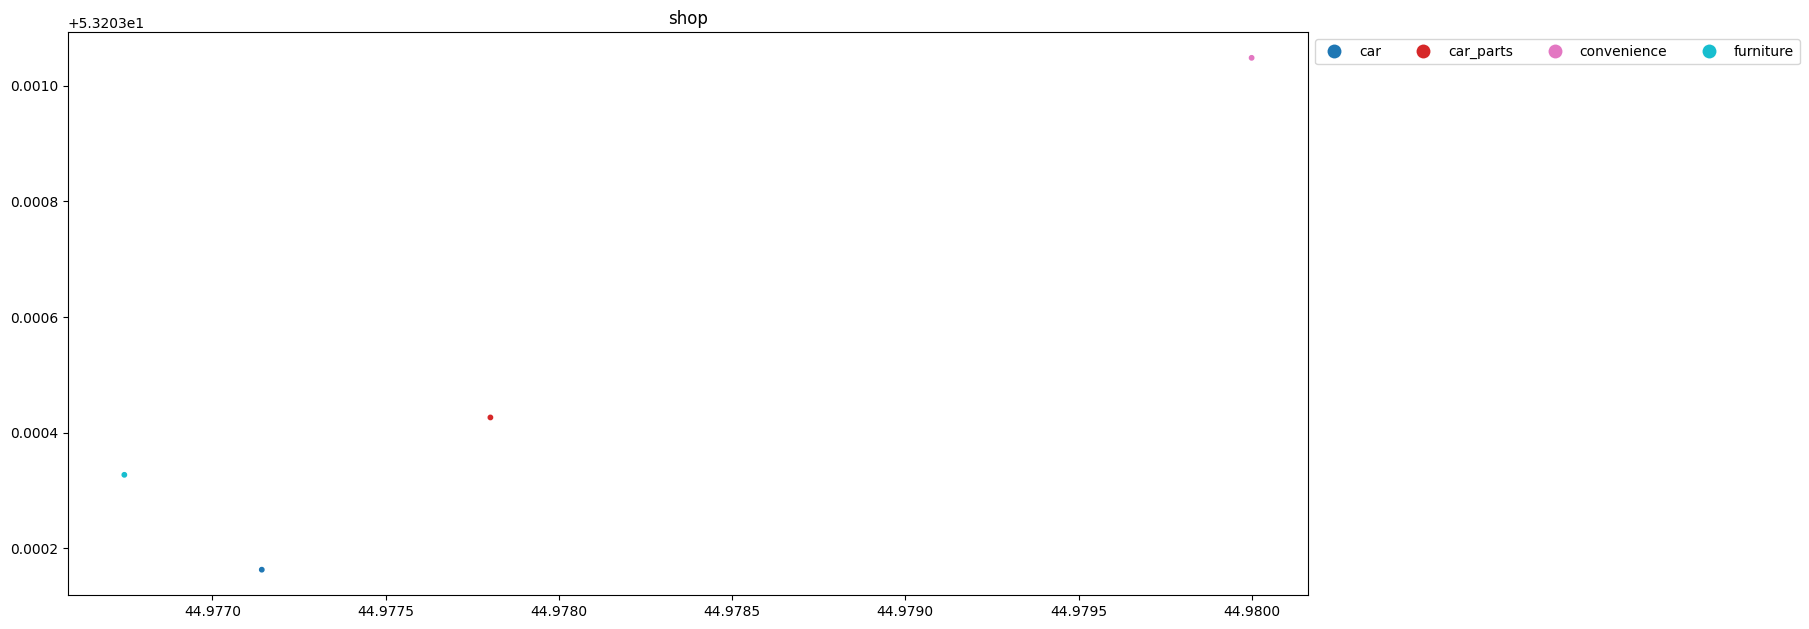

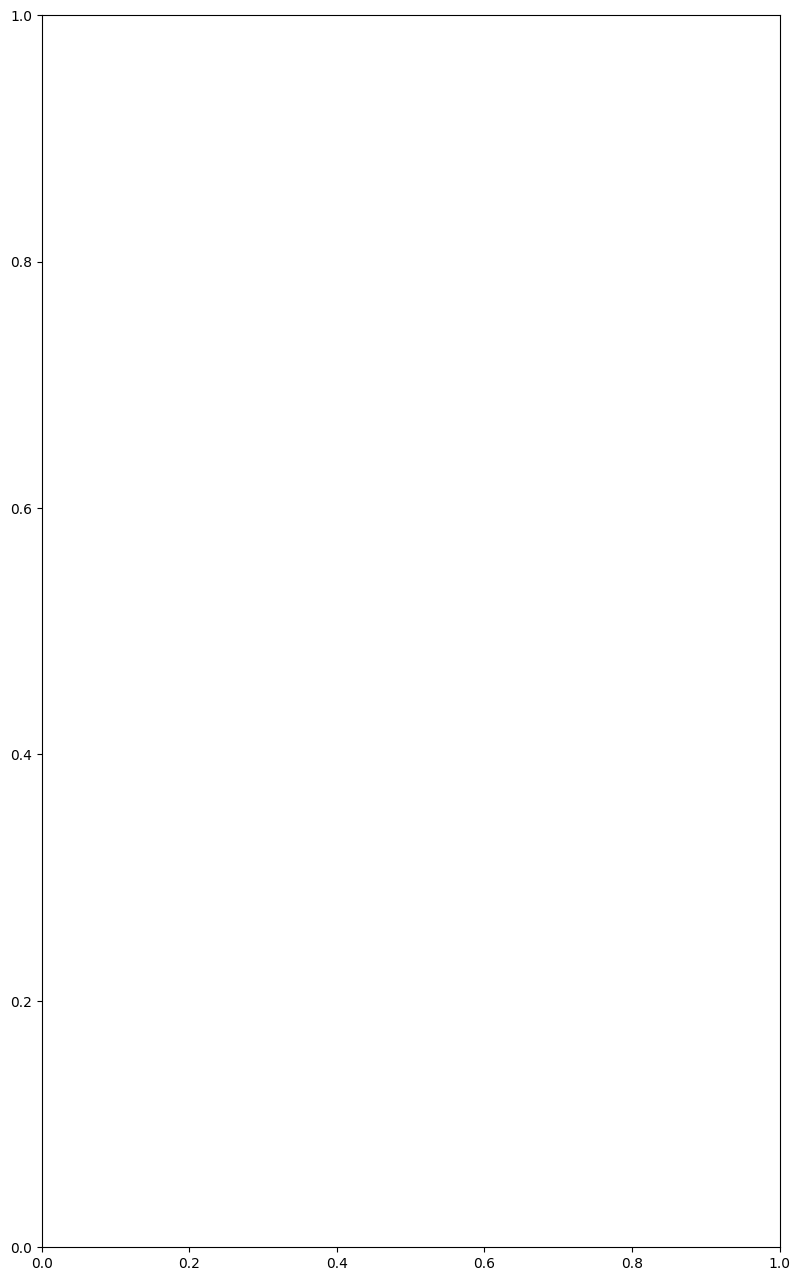

In [98]:
# Координаты адреса "Москва, Чистопрудный бульвар, 1"
lon = 44.978826
lat = 53.203220
tag_types = my_filter.keys()

searching_radius = 150 # m

poi_out = get_poi_count_near_point_using_r_tree(
    main_gpdf, lon, lat, searching_radius, tag_types, True
)
print(f"Количество точек интереса по типам в радиусе {searching_radius} м от точки "
      f"с координатами lon: {lon}, lat: {lat}")
pprint(poi_out)


In [84]:
# Описание тегов можно получить на странице https://wiki.openstreetmap.org/wiki/Map_features#

categories = (
    "sustenance",  # бары, кафе, пабы, рестораны, фаст-фуд, магазины мороженного, фуд-корты
    "education", # школы (не только общеобразовательные), колледжи, детские садики,
    # библиотеки (не только книги), институты, университеты
    "fuel",  # заправочные станции для автомобилей
    "car_service", # ремонт, шиномонтаж, автомойка
    "parking_space",  # парковочное пространство (несколько парковочных мест,
    # объединенных в группу)
    "atm",  # банкомат
    "bank",  # банк
    "bureau_de_change",  # обменный пункт
    "outpatient_medical_facilities", # амбулаторные мед учреждения (поликлиники,
    # стоматология и т.п.)
    "inplace_medical_facilities",  # госпитали, хосписы и т.п.
    "pharmacy",  # аптеки
    "veterinary",  # ветеринарные клиники
    "entertainment",  # развлечения и искусство (кино, театры, концертные залы, выставки,
    # планетарии и т.п.)
    "entertainment_for_adults",  # ночные клубы, стриптиз
    "administrative_buildings",  # административные здания (суды, правительство и т.п.)
    "police",  # полицейский участок
    "fire_station",  # пожарная станция
    "post_office",  # почтова служба
    "grave_yard",  # кладбище
    "marketplace",  # рынок
    "monastery",  # монастырь
    "place_of_worship",  # храмы, мечети и т.п.
    "public_transport_stop_position",  # место остановки общественного транспорта
    "alcohol_shop",  # магазин, продающий алкогольные напитки
    "food_shop", # продовольственные магазины (фрукты, овощи, бакалея, мясо, рыба и т.п.)
    "supermarket",  # супермаркет, универсам, главный магазин
    "mall",  # молл
    "wholesale",  # оптовый магазин (типа METRO Cash & Carry)
    "clothing_shop",  # магазин одежды, обуви и аксессуаров
    "discount_store",  # благотворительные магазины, секонд хэнд, фикс прайс
    "beauty_store",  # магазины health and beauty
    "hardware_store", # строительство, товары для сада и дачи, ремонт
    "interior_store",  # мебель и интерьер
    "electronics_store",  # магазины электроники
    "sport_store",  # магазины спортивных товаров
    "auto_moto_store",  # авто-мото салон
    "car_parts_store",  # магазины авто и мото запчастей
    "hobbies_store",  # магазины, посвященные искусству, музыке, хобби
    "books_store",  # книжные магазины, журналы, подарки, комиксы
    "other_type_store",  # прочие типы магазинов (см вики)
    "hotel",  # hostel, hotel, motel
    "museum",  # музей
)
tags = {
    # amenity
    # sustenance
    "bar": {
        "key": "amenity",
        "category": "sustenance",
    },
    "cafe": {
        "key": "amenity",
        "category": "sustenance",
    },
    "fast_food": {
        "key": "amenity",
        "category": "sustenance",
    },
    "food_court": {
        "key": "amenity",
        "category": "sustenance",
    },
    "pub": {
        "key": "amenity",
        "category": "sustenance",
    },
    "ice_cream": {
        "key": "amenity",
        "category": "sustenance",
    },
    "restaurant": {
        "key": "amenity",
        "category": "sustenance",
    },
    # amenity
    # education
    "college": {
        "key": "amenity",
        "category": "education",
    },
    "dancing_school": {
        "key": "amenity",
        "category": "education",
    },
    "driving_school": {
        "key": "amenity",
        "category": "education",
    },
    "first_aid_school": {
        "key": "amenity",
        "category": "education",
    },
    "kindergarten": {
        "key": "amenity",
        "category": "education",
    },
    "language_school": {
        "key": "amenity",
        "category": "education",
    },
    "library": {
        "key": "amenity",
        "category": "education",
    },
    "research_institute": {
        "key": "amenity",
        "category": "education",
    },
    "music_school": {
        "key": "amenity",
        "category": "education",
    },
    "school": {
        "key": "amenity",
        "category": "education",
    },
    "university": {
        "key": "amenity",
        "category": "education",
    },
    # amenity
    # transportation
    "fuel": {
        "key": "amenity",
        "category": "fuel",
    },
    "car_wash": {
        "key": "amenity",
        "category": "car_service",
    },
    "parking_space": {
        "key": "amenity",
        "category": "parking_space",
    },
    # amenity
    # financial
    "atm": {
        "key": "amenity",
        "category": "atm",
    },
    "bank": {
        "key": "amenity",
        "category": "bank",
    },
    "bureau_de_change": {
        "key": "amenity",
        "category": "bureau_de_change",
    },
    # amenity
    # healthcare
    "clinic": {
        "key": "amenity",
        "category": "outpatient_medical_facilities"
    },
    "dentist": {
        "key": "amenity",
        "category": "outpatient_medical_facilities"
    },
    "doctors": {
        "key": "amenity",
        "category": "outpatient_medical_facilities"
    },
    "hospital": {
        "key": "amenity",
        "category": "inplace_medical_facilities",
    },
    "nursing_home": {
        "key": "amenity",
        "category": "inplace_medical_facilities",
    },
    "pharmacy": {
        "key": "amenity",
        "category": "pharmacy",
    },
    "veterinary": {
        "key": "amenity",
        "category": "veterinary"
    },
    # amenity
    # entertainment, arts and culture
    "arts_centre": {
        "key": "amenity",
        "category": "entertainment",
    },
    "cinema": {
        "key": "amenity",
        "category": "entertainment",
    },
    "community_centre": {
        "key": "amenity",
        "category": "entertainment",
    },
    "conference_centre": {
        "key": "amenity",
        "category": "entertainment",
    },
    "events_venue": {
        "key": "amenity",
        "category": "entertainment",
    },
    "exhibition_centre": {
        "key": "amenity",
        "category": "entertainment",
    },
    "music_venue": {
        "key": "amenity",
        "category": "entertainment",
    },
    "planetarium": {
        "key": "amenity",
        "category": "entertainment",
    },
    "social_centre": {
        "key": "amenity",
        "category": "entertainment",
    },
    "theatre": {
        "key": "amenity",
        "category": "entertainment",
    },
    "nightclub": {
        "key": "amenity",
        "category": "entertainment_for_adults",
    },
    "stripclub": {
        "key": "amenity",
        "category": "entertainment_for_adults",
    },
    # amenity
    # public service
    "courthouse": {
        "key": "amenity",
        "category": "administrative_buildings",
    },
    "townhall": {
        "key": "amenity",
        "category": "administrative_buildings",
    },
    "fire_station": {
        "key": "amenity",
        "category": "fire_station",
    },
    "police": {
        "key": "amenity",
        "category": "police",
    },
    "post_office": {
        "key": "amenity",
        "category": "post_office",
    },
    # amenity
    # others
    "grave_yard": {
        "key": "amenity",
        "category": "grave_yard",
    },
    "marketplace": {
        "key": "amenity",
        "category": "marketplace",
    },
    "monastery": {
        "key": "amenity",
        "category": "monastery",
    },
    "place_of_worship": {
        "key": "amenity",
        "category": "place_of_worship",
    },
    # public transport
    "stop_position": {
        "key": "public_transport",
        "category": "public_transport_stop_position",
    },
    # shop
    # food, beverages
    "alcohol": {
        "key": "shop",
        "category": "alcohol_shop",
    },
    "beverages": {
        "key": "shop",
        "category": "alcohol_shop",
    },
    "brewing_supplies": {
        "key": "shop",
        "category": "alcohol_shop",
    },
    "wine": {
        "key": "shop",
        "category": "alcohol_shop",
    },
    "bakery": {
        "key": "shop",
        "category": "food_shop",
    },
    "butcher": {
        "key": "shop",
        "category": "food_shop",
    },
    "cheese": {
        "key": "shop",
        "category": "food_shop",
    },
    "chocolate": {
        "key": "shop",
        "category": "food_shop",
    },
    "coffee": {
        "key": "shop",
        "category": "food_shop",
    },
    "confectionery": {
        "key": "shop",
        "category": "food_shop",
    },
    "convenience": {
        "key": "shop",
        "category": "food_shop",
    },
    "deli": {
        "key": "shop",
        "category": "food_shop",
    },
    "dairy": {
        "key": "shop",
        "category": "food_shop",
    },
    "farm": {
        "key": "shop",
        "category": "food_shop",
    },
    "frozen_food": {
        "key": "shop",
        "category": "food_shop",
    },
    "greengrocer": {
        "key": "shop",
        "category": "food_shop",
    },
    "health_food": {
        "key": "shop",
        "category": "food_shop",
    },
    "pasta": {
        "key": "shop",
        "category": "food_shop",
    },
    "pastry": {
        "key": "shop",
        "category": "food_shop",
    },
    "seafood": {
        "key": "shop",
        "category": "food_shop",
    },
    "spices": {
        "key": "shop",
        "category": "food_shop",
    },
    "tea": {
        "key": "shop",
        "category": "food_shop",
    },
    "water": {
        "key": "shop",
        "category": "food_shop",
    },
    "food": {
        "key": "shop",
        "category": "food_shop",
    },
    # shop
    # general store, department store, mall
    "department_store": {
        "key": "shop",
        "category": "mall",
    },
    "mall": {
        "key": "shop",
        "category": "mall",
    },
    "general": {
        "key": "shop",
        "category": "supermarket",
    },
    "supermarket": {
        "key": "shop",
        "category": "supermarket",
    },
    "wholesale": {
        "key": "shop",
        "category": "wholesale",
    },
    # shop
    # clothing, shoes, accessories
    "baby_goods": {
        "key": "shop",
        "category": "clothing_shop",
    },
    "bag": {
        "key": "shop",
        "category": "clothing_shop",
    },
    "boutique": {
        "key": "shop",
        "category": "clothing_shop",
    },
    "clothes": {
        "key": "shop",
        "category": "clothing_shop",
    },
    "fabric": {
        "key": "shop",
        "category": "clothing_shop",
    },
    "fashion_accessories": {
        "key": "shop",
        "category": "clothing_shop",
    },
    "jewelry": {
        "key": "shop",
        "category": "clothing_shop",
    },
    "sewing": {
        "key": "shop",
        "category": "clothing_shop",
    },
    "shoes": {
        "key": "shop",
        "category": "clothing_shop",
    },
    "tailor": {
        "key": "shop",
        "category": "clothing_shop",
    },
    "watches": {
        "key": "shop",
        "category": "clothing_shop",
    },
    "wool": {
        "key": "shop",
        "category": "clothing_shop",
    },
    # shop
    # discount store, charity
    "charity": {
        "key": "shop",
        "category": "discount_store",
    },
    "second_hand": {
        "key": "shop",
        "category": "discount_store",
    },
    "variety_store": {
        "key": "shop",
        "category": "discount_store",
    },
    # shop
    # health and beauty
    "beauty": {
        "key": "shop",
        "category": "beauty_store",
    },
    "chemist": {
        "key": "shop",
        "category": "beauty_store",
    },
    "cosmetics": {
        "key": "shop",
        "category": "beauty_store",
    },
    "erotic": {
        "key": "shop",
        "category": "beauty_store",
    },
    "hairdresser": {
        "key": "shop",
        "category": "beauty_store",
    },
    "hairdresser_supply": {
        "key": "shop",
        "category": "beauty_store",
    },
    "hearing_aids": {
        "key": "shop",
        "category": "beauty_store",
    },
    "herbalist": {
        "key": "shop",
        "category": "beauty_store",
    },
    "massage": {
        "key": "shop",
        "category": "beauty_store",
    },
    "medical_supply": {
        "key": "shop",
        "category": "beauty_store",
    },
    "nutrition_supplements": {
        "key": "shop",
        "category": "beauty_store",
    },
    "optician": {
        "key": "shop",
        "category": "beauty_store",
    },
    "perfumery": {
        "key": "shop",
        "category": "beauty_store",
    },
    # shop
    # do-it-yourself, household, building materials, gardening
    "agrarian": {
        "key": "shop",
        "category": "hardware_store",
    },
    "appliance": {
        "key": "shop",
        "category": "hardware_store",
    },
    "bathroom_furnishing": {
        "key": "shop",
        "category": "hardware_store",
    },
    "doityourself": {
        "key": "shop",
        "category": "hardware_store",
    },
    "electrical": {
        "key": "shop",
        "category": "hardware_store",
    },
    "energy": {
        "key": "shop",
        "category": "hardware_store",
    },
    "fireplace": {
        "key": "shop",
        "category": "hardware_store",
    },
    "florist": {
        "key": "shop",
        "category": "hardware_store",
    },
    "garden_centre": {
        "key": "shop",
        "category": "hardware_store",
    },
    "garden_furniture": {
        "key": "shop",
        "category": "hardware_store",
    },
    "gas": {
        "key": "shop",
        "category": "hardware_store",
    },
    "glaziery": {
        "key": "shop",
        "category": "hardware_store",
    },
    "groundskeeping": {
        "key": "shop",
        "category": "hardware_store",
    },
    "hardware": {
        "key": "shop",
        "category": "hardware_store",
    },
    "houseware": {
        "key": "shop",
        "category": "hardware_store",
    },
    "locksmith": {
        "key": "shop",
        "category": "hardware_store",
    },
    "paint": {
        "key": "shop",
        "category": "hardware_store",
    },
    "pottery": {
        "key": "shop",
        "category": "hardware_store",
    },
    "security": {
        "key": "shop",
        "category": "hardware_store",
    },
    # shop
    # furniture and interior
    "antiques": {
        "key": "shop",
        "category": "interior_store",
    },
    "bed": {
        "key": "shop",
        "category": "interior_store",
    },
    "candles": {
        "key": "shop",
        "category": "interior_store",
    },
    "carpet": {
        "key": "shop",
        "category": "interior_store",
    },
    "curtain": {
        "key": "shop",
        "category": "interior_store",
    },
    "doors": {
        "key": "shop",
        "category": "interior_store",
    },
    "flooring": {
        "key": "shop",
        "category": "interior_store",
    },
    "furniture": {
        "key": "shop",
        "category": "interior_store",
    },
    "household_linen": {
        "key": "shop",
        "category": "interior_store",
    },
    "interior_decoration": {
        "key": "shop",
        "category": "interior_store",
    },
    "kitchen": {
        "key": "shop",
        "category": "interior_store",
    },
    "lighting": {
        "key": "shop",
        "category": "interior_store",
    },
    "tiles": {
        "key": "shop",
        "category": "interior_store",
    },
    "window_blind": {
        "key": "shop",
        "category": "interior_store",
    },
    # shop
    # electronics
    "computer": {
        "key": "shop",
        "category": "electronics_store",
    },
    "electronics": {
        "key": "shop",
        "category": "electronics_store",
    },
    "hifi": {
        "key": "shop",
        "category": "electronics_store",
    },
    "mobile_phone": {
        "key": "shop",
        "category": "electronics_store",
    },
    "radiotechnics": {
        "key": "shop",
        "category": "electronics_store",
    },
    "telecommunication": {
        "key": "shop",
        "category": "electronics_store",
    },
    "vacuum_cleaner": {
        "key": "shop",
        "category": "electronics_store",
    },
    "printer_ink": {
        "key": "shop",
        "category": "electronics_store",
    },
    # shop
    # outdoors and sport, vehicles
    "atv": {
        "key": "shop",
        "category": "auto_moto_store",
    },
    "bicycle": {
        "key": "shop",
        "category": "sport_store",
    },
    "car": {
        "key": "shop",
        "category": "auto_moto_store",
    },
    "car_repair": {
        "key": "shop",
        "category": "car_parts_store",
    },
    "motorcycle_repair": {
        "key": "shop",
        "category": "car_parts_store",
    },
    "car_parts": {
        "key": "shop",
        "category": "car_parts_store",
    },
    "caravan": {
        "key": "shop",
        "category": "auto_moto_store",
    },
    "fishing": {
        "key": "shop",
        "category": "sport_store",
    },
    "surf": {
        "key": "shop",
        "category": "sport_store",
    },
    "golf": {
        "key": "shop",
        "category": "sport_store",
    },
    "hunting": {
        "key": "shop",
        "category": "sport_store",
    },
    "jetski": {
        "key": "shop",
        "category": "sport_store",
    },
    "motorcycle": {
        "key": "shop",
        "category": "auto_moto_store",
    },
    "outdoor": {
        "key": "shop",
        "category": "sport_store",
    },
    "scuba_diving": {
        "key": "shop",
        "category": "sport_store",
    },
    "ski": {
        "key": "shop",
        "category": "sport_store",
    },
    "snowmobile": {
        "key": "shop",
        "category": "auto_moto_store",
    },
    "sports": {
        "key": "shop",
        "category": "sport_store",
    },
    "swimming_pool": {
        "key": "shop",
        "category": "sport_store",
    },
    "trailer": {
        "key": "shop",
        "category": "auto_moto_store",
    },
    "tyres": {
        "key": "shop",
        "category": "car_parts_store",
    },
    # shop
    # art, music, hobbies
    "art": {
        "key": "shop",
        "category": "hobbies_store",
    },
    "model": {
        "key": "shop",
        "category": "hobbies_store",
    },
    "music": {
        "key": "shop",
        "category": "hobbies_store",
    },
    "musical_instrument": {
        "key": "shop",
        "category": "hobbies_store",
    },
    "photo": {
        "key": "shop",
        "category": "hobbies_store",
    },
    "trophy": {
        "key": "shop",
        "category": "hobbies_store",
    },
    "video": {
        "key": "shop",
        "category": "hobbies_store",
    },
    "video_games": {
        "key": "shop",
        "category": "hobbies_store",
    },
    "camera": {
        "key": "shop",
        "category": "hobbies_store",
    },
    "collector": {
        "key": "shop",
        "category": "hobbies_store",
    },
    "craft": {
        "key": "shop",
        "category": "hobbies_store",
    },
    "frame": {
        "key": "shop",
        "category": "hobbies_store",
    },
    "games": {
        "key": "shop",
        "category": "hobbies_store",
    },
    # shop
    # stationery, gifts, books, newspapers
    "books": {
        "key": "shop",
        "category": "books_store",
    },
    "gift": {
        "key": "shop",
        "category": "books_store",
    },
    "lottery": {
        "key": "shop",
        "category": "books_store",
    },
    "newsagent": {
        "key": "shop",
        "category": "books_store",
    },
    "stationery": {
        "key": "shop",
        "category": "books_store",
    },
    "ticket": {
        "key": "shop",
        "category": "books_store",
    },
    "anime": {
        "key": "shop",
        "category": "books_store",
    },
    # shop
    # others
    "bookmaker": {
        "key": "shop",
        "category": "other_type_store",
    },
    "copyshop": {
        "key": "shop",
        "category": "other_type_store",
    },
    "dry_cleaning": {
        "key": "shop",
        "category": "other_type_store",
    },
    "e-cigarette": {
        "key": "shop",
        "category": "other_type_store",
    },
    "funeral_directors": {
        "key": "shop",
        "category": "other_type_store",
    },
    "insurance": {
        "key": "shop",
        "category": "other_type_store",
    },
    "laundry": {
        "key": "shop",
        "category": "other_type_store",
    },
    "money_lender": {
        "key": "shop",
        "category": "other_type_store",
    },
    "outpost": {
        "key": "shop",
        "category": "other_type_store",
    },
    "party": {
        "key": "shop",
        "category": "other_type_store",
    },
    "pawnbroker": {
        "key": "shop",
        "category": "other_type_store",
    },
    "pest_control": {
        "key": "shop",
        "category": "other_type_store",
    },
    "pet": {
        "key": "shop",
        "category": "other_type_store",
    },
    "pet_grooming": {
        "key": "shop",
        "category": "other_type_store",
    },
    "pyrotechnics": {
        "key": "shop",
        "category": "other_type_store",
    },
    "religion": {
        "key": "shop",
        "category": "other_type_store",
    },
    "storage_rental": {
        "key": "shop",
        "category": "other_type_store",
    },
    "tobacco": {
        "key": "shop",
        "category": "other_type_store",
    },
    "toys": {
        "key": "shop",
        "category": "other_type_store",
    },
    "travel_agency": {
        "key": "shop",
        "category": "other_type_store",
    },
    "weapons": {
        "key": "shop",
        "category": "other_type_store",
    },
    # tourism
    "hostel": {
        "key": "tourism",
        "category": "hotel",
    },
    "hotel": {
        "key": "tourism",
        "category": "hotel",
    },
    "motel": {
        "key": "tourism",
        "category": "hotel",
    },
    "museum": {
        "key": "tourism",
        "category": "museum",
    },
}

In [85]:
def convert_poi_tag_counts_to_category_counts(pois_in: dict[dict]) -> dict:
    """Преобразует словарь с количеством точек интереса по ключам OSM в словарь
    с количеством точек интереса по заданным категориям"""
    counter = Counter()
    for key in pois_in.keys():
        for tag in pois_in[key].keys():
            tag_info = tags.get(tag)
            if tag_info is None:
                continue
            category = tag_info["category"]
            counter[category] += pois_in[key][tag]
    return dict(counter)

In [86]:
convert_poi_tag_counts_to_category_counts(poi_out)


{'sustenance': 14,
 'outpatient_medical_facilities': 3,
 'atm': 2,
 'bank': 1,
 'pharmacy': 1,
 'bureau_de_change': 1,
 'food_shop': 3,
 'other_type_store': 8,
 'hardware_store': 2,
 'books_store': 3,
 'supermarket': 1,
 'clothing_shop': 1,
 'interior_store': 1,
 'electronics_store': 1,
 'hobbies_store': 1,
 'beauty_store': 1,
 'alcohol_shop': 1,
 'public_transport_stop_position': 4,
 'hotel': 1}

In [87]:
df_init = pd.read_csv("../datasets/train_initial.csv", index_col=0)

In [88]:
df_init.head(5)


,id,atm_group,address,address_rus,lat,long,target
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277


In [30]:
df_full = pd.read_csv("../datasets/train.csv", index_col=0)
df_full = df_full.sort_index()

In [35]:
df_full.head(5)

,id,atm_group,address,address_rus,lat,long,target,area_fias_id,area_with_type,city_with_type,...,metro_distance_2,metro_station_name_3,metro_line_name_3,metro_distance_3,street,house_fias_id,house,metro,locality_area,locality_population
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,NaN,NaN,г Южно-Сахалинск,...,NaN,NaN,NaN,NaN,Емельянова А.О.,1fa1647b-4e7c-4e8a-8190-67e9b4113409,34,NaN,207.740736,200636.0
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,NaN,NaN,г Южно-Сахалинск,...,NaN,NaN,NaN,NaN,Комсомольская,67d5df97-5d2a-4c23-b55e-9fc85bd128b8,259,NaN,207.740736,200636.0
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,NaN,NaN,г Южно-Сахалинск,...,NaN,NaN,NaN,NaN,Коммунистический,ccd6e538-d195-41a3-913c-3c7fd54bf60a,28,NaN,207.740736,200636.0
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,NaN,NaN,г Москва,...,1.1,Панфиловская,МЦК,1.3,Ленинградский,11c4e990-87e1-41e8-b430-14dee8466831,76А,0.0,2562.617022,12678079.0
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,NaN,NaN,г Норильск,...,NaN,NaN,NaN,NaN,Гвардейская,52ad0d91-8f74-4636-926b-65e2a246d124,2,NaN,4511.953383,181830.0


В качестве основы использую датасет `train_initial.csv`, т.к. в `train.csv` есть ошибки с координатами банкоматов. Нужно еще разобраться, в чем дело.

In [100]:
df = df_init.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6261 entries, 0 to 6260
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6261 non-null   float64
 1   atm_group    6261 non-null   float64
 2   address      6261 non-null   object 
 3   address_rus  5957 non-null   object 
 4   lat          5957 non-null   float64
 5   long         5957 non-null   float64
 6   target       6261 non-null   float64
dtypes: float64(5), object(2)
memory usage: 391.3+ KB


In [109]:
for category in categories:
    df.loc[:, category] = pd.Series(dtype='int64')
    df.loc[:, category] = None

searching_radius = 150 # m

successful_rows = []
rows_with_errors = []

for index, row in tqdm(df.iterrows()):
    if np.isnan(row["lat"]) or np.isnan(row["long"]):
        rows_with_errors.append(index)
        continue
    try:
        poi_data = get_poi_count_near_point_using_r_tree(
            main_gpdf, row["long"], row["lat"],
            searching_radius, tag_types, False
        )
        converted_poi_data = convert_poi_tag_counts_to_category_counts(poi_data)
        for found_category in categories:
            df.at[index, found_category] = converted_poi_data.get(found_category, 0)
    except Exception as exc:
        print(f"Exception for row {index}: {exc}")
        print(f"for row index {index} lat = {row['lat']}, {type(row['lat'])}, long = {row['long']}, {type(row['long'])}")
        rows_with_errors.append(index)
    else:
        successful_rows.append(index)


2977it [00:08, 396.42it/s]

Exception for row 2932: TopologyException: side location conflict at 142.74678039550781 46.964622497558594. This can occur if the input geometry is invalid.
for row index 2932 lat = 46.967586, <class 'float'>, long = 142.752575, <class 'float'>


3747it [00:10, 396.92it/s]

Exception for row 3702: TopologyException: side location conflict at 142.74678039550781 46.964622497558594. This can occur if the input geometry is invalid.
for row index 3702 lat = 46.960926, <class 'float'>, long = 142.744455, <class 'float'>


6261it [00:16, 372.24it/s]


In [114]:
df.head(10)


,id,atm_group,address,address_rus,lat,long,target,sustenance,education,fuel,...,interior_store,electronics_store,sport_store,auto_moto_store,car_parts_store,hobbies_store,books_store,other_type_store,hotel,museum
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,0,2,0,...,0,5,0,0,0,1,2,1,0,0
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,0,1,0,...,1,5,0,0,0,0,0,2,0,0
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,0,3,0,...,0,0,0,0,0,0,0,0,1,0
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,12,1,0,...,2,4,0,0,0,0,1,11,0,0
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,2,1,0,...,0,1,0,0,0,0,1,0,0,0
5,313.0,32.0,"RUSSKAYA, 16 VLADIVOSTOK","Русская улица, 16, Владивосток, Приморский кра...",43.165860,131.908212,-0.145001,3,1,0,...,2,6,0,1,1,0,2,2,0,0
6,335.0,32.0,"SHUKHOVA, 14 MOSCOW","улица Шухова, 14, Москва, Россия, 115162",55.716859,37.613063,-0.024682,2,1,0,...,0,0,0,0,0,0,0,3,0,1
7,358.0,32.0,"ADMIRALA FOKINA, 25 VLADIVOSTOK","улица Адмирала Фокина, 25, Владивосток, Примор...",43.117174,131.885503,-0.133426,17,1,0,...,0,7,0,0,0,0,1,0,1,1
8,2895.0,32.0,Zhivopisnaia 136 d.Velednikov,"деревня Веледниково, городской округ Истра, Мо...",55.799765,37.116016,0.141469,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1975.0,496.5,BEKESHSKAYA 39 PENZA,"Бекешская улица, 39, Пенза, Россия, 440018",53.203220,44.978826,0.017259,0,1,1,...,1,0,0,1,1,0,0,0,0,0


In [112]:
len(rows_with_errors)


306

In [113]:
df.to_csv('train_initial_with_pois.csv')
